In [1]:
import os
import sys

parent_dir = os.path.dirname('/home/jupyter/')
sys.path.append(parent_dir)

import warnings
warnings.filterwarnings("ignore")

import gc
import time
import collections
import numpy as np
import pandas as pd
import scanpy as sc

import torch
import torch.nn.functional as F
torch.manual_seed(0)

from multivib.multiVIB import multivibS, multivibLoRAS
from multivib.multiVIB import multivib_species_training

from multivib.multiVIB import scale_by_batch

from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load subset of cross-species basal ganglia data
file = '../data/public-anndata-project_373_1__published__9zHyztVj-HLS2q5HpUK-E_1539.h5ad'
ref_rna = sc.read_h5ad(file)
sc.pp.subsample(ref_rna, fraction=0.5)

ref_rna.X = ref_rna.layers['UMIs'].copy()
ref_rna.var.index = ref_rna.var['gene_names'].values
ref_rna = ref_rna[:, ~ref_rna.var.index.duplicated()]

sc.pp.normalize_total(ref_rna, target_sum=1e4)
sc.pp.log1p(ref_rna)

In [3]:
query_rna1 = ref_rna[ref_rna.obs['organism']=='Callithrix jacchus']
query_rna2 = ref_rna[ref_rna.obs['organism']=='Macaca Mulatta']
query_rna3 = ref_rna[ref_rna.obs['organism']=='Homo sapiens']

In [4]:
print(query_rna3.X.shape)
print(query_rna1.X.shape)
print(query_rna2.X.shape)
gc.collect()

(38486, 16253)
(30683, 16253)
(39451, 16253)


0

In [5]:
import collections
gc.collect()

0

In [6]:
## identify highly variable features in each species
sc.pp.highly_variable_genes(query_rna1, n_top_genes=2000, flavor="seurat",
                            subset=True, batch_key='donor_id', min_mean=0.05)
sc.pp.highly_variable_genes(query_rna2, n_top_genes=2000, flavor="seurat",
                            subset=True, batch_key='donor_id', min_mean=0.05)
sc.pp.highly_variable_genes(query_rna3, n_top_genes=2000, flavor="seurat",
                            subset=True, batch_key='donor_id', min_mean=0.05)

In [7]:
all_genes = query_rna1.var.index.tolist()+query_rna2.var.index.tolist()+query_rna3.var.index.tolist()
all_genes = list(set(all_genes))
ref_rna = ref_rna[:, all_genes]

In [8]:
query_rna1 = ref_rna[ref_rna.obs['organism']=='Callithrix jacchus']
query_rna2 = ref_rna[ref_rna.obs['organism']=='Macaca Mulatta']
query_rna3 = ref_rna[ref_rna.obs['organism']=='Homo sapiens']

In [9]:
## identify highly variable features in all 3 species
sc.pp.highly_variable_genes(ref_rna, n_top_genes=1000, flavor="seurat",
                            subset=True, batch_key='donor_id', min_mean=0.05)

Next, we set up a mask for each species

In [10]:
## Callithrix jacchus
maskA = torch.zeros((ref_rna.X.shape[1], query_rna1.X.shape[1]))

query_feat = np.repeat(query_rna1.var.index, ref_rna.X.shape[1])
rna_feat = np.tile(ref_rna.var.index, query_rna1.X.shape[1])

mask_boolen = (query_feat == rna_feat).reshape(maskA.T.shape)
maskA[mask_boolen.T] = 1

## Macaca Mulatta
maskB = torch.zeros((ref_rna.X.shape[1], query_rna2.X.shape[1]))

query_feat = np.repeat(query_rna2.var.index, ref_rna.X.shape[1])
rna_feat = np.tile(ref_rna.var.index, query_rna2.X.shape[1])

mask_boolen = (query_feat == rna_feat).reshape(maskB.T.shape)
maskB[mask_boolen.T] = 1

## Human
maskC = torch.zeros((ref_rna.X.shape[1], query_rna3.X.shape[1]))

query_feat = np.repeat(query_rna3.var.index, ref_rna.X.shape[1])
rna_feat = np.tile(ref_rna.var.index, query_rna3.X.shape[1])

mask_boolen = (query_feat == rna_feat).reshape(maskC.T.shape)
maskC[mask_boolen.T] = 1

In [11]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.expand_dims(
    ref_rna.obs['donor_id'].values,
    axis=1))
Cj_batch = enc.transform(np.expand_dims(query_rna1.obs['donor_id'], 1))
Mm_batch = enc.transform(np.expand_dims(query_rna2.obs['donor_id'], 1))
Hs_batch = enc.transform(np.expand_dims(query_rna3.obs['donor_id'], 1))

Cj_batch = np.asarray(Cj_batch.todense())
Mm_batch = np.asarray(Mm_batch.todense())
Hs_batch = np.asarray(Hs_batch.todense())

In [12]:
print(Cj_batch.shape)

(30683, 22)


In [13]:
gc.collect()

10394

In [14]:
## Scale data

X_cj = np.asarray(query_rna1.X.todense())
X_mm = np.asarray(query_rna2.X.todense())
X_hs = np.asarray(query_rna3.X.todense())

X_cj = scale_by_batch(X_cj, query_rna1.obs['donor_id'].values)
X_mm = scale_by_batch(X_mm, query_rna2.obs['donor_id'].values)
X_hs = scale_by_batch(X_hs, query_rna3.obs['donor_id'].values)

gc.collect()

0

In [15]:
integrater = multivibS(
    n_shared_input=ref_rna.X.shape[1],
    n_input=[X_cj.shape[1], X_mm.shape[1], X_hs.shape[1]],
    masks=[maskA, maskB, maskC],
    relations=['positive', 'positive', 'positive'],
    n_hidden=256, n_latent=10, n_batch=22
)

In [16]:
start_time = time.time()
loss_history = multivib_species_training(
    integrater, 
    [X_cj, X_mm, X_hs],
    [Cj_batch, Mm_batch, Hs_batch],
    epoch=100, temp=0.15, batch_size=256, alpha=0.02,
)

print("--- %s minutes ---" % int((time.time() - start_time)/60))

--- 17 minutes ---


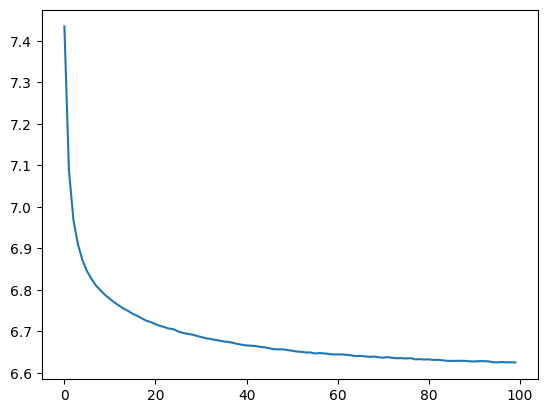

3694

In [17]:
plt.plot(loss_history, linestyle = 'solid')
plt.show()
gc.collect()

Matrix decomposition

In [18]:
rank = 256

In [19]:
weight = torch.cat([integrater.translators[0][0].weight.data, 
                    integrater.translators[1][0].weight.data, 
                    integrater.translators[2][0].weight.data], 1).T

In [20]:
allmask = torch.cat([maskA, maskB, maskC],1).T
weight[allmask!=1]=0

In [21]:
svd_decomp = torch.svd_lowrank(weight, q=rank, niter=100)

We next set up a 2nd integrator that has another form of translator and copy trained weights in the 1st phase to the 2nd form of translator.

In [22]:
integraterB = multivibLoRAS(
    n_shared_input=ref_rna.X.shape[1],
    n_input=[X_cj.shape[1], X_mm.shape[1], X_hs.shape[1]],
    n_hidden=256, n_latent=10, n_batch=22, rank=rank
)

In [23]:
integraterB.matrixB.weight.data = svd_decomp[2].data.to(
    integraterB.matrixB.weight.device, 
    integraterB.matrixB.weight.dtype
)

integraterB.matrixA[0].weight.data = svd_decomp[0][:X_cj.shape[1],:].T.data.to(
    integraterB.matrixA[0].weight.device, 
    integraterB.matrixA[0].weight.dtype
)

integraterB.matrixA[1].weight.data = svd_decomp[0][X_cj.shape[1]:(X_cj.shape[1]+X_mm.shape[1]),:].T.data.to(
    integraterB.matrixA[1].weight.device, 
    integraterB.matrixA[1].weight.dtype
)

integraterB.matrixA[2].weight.data = svd_decomp[0][(X_cj.shape[1]+X_mm.shape[1]):,:].T.data.to(
    integraterB.matrixA[2].weight.device, 
    integraterB.matrixA[2].weight.dtype
)

for param in integrater.encoder.parameters():
    param.requires_grad = False
                    
for param in integrater.projecter.parameters():
    param.requires_grad = False

integraterB.encoder.load_state_dict(integrater.encoder.state_dict())
integraterB.projecter.load_state_dict(integrater.projecter.state_dict())

<All keys matched successfully>

In [24]:
loss_history = multivib_species_training(
    integraterB,
    [X_cj, X_mm, X_hs],
    [Cj_batch, Mm_batch, Hs_batch],
    epoch=200, temp=0.15, batch_size=256, alpha=0.02, param_setup='2nd'
)

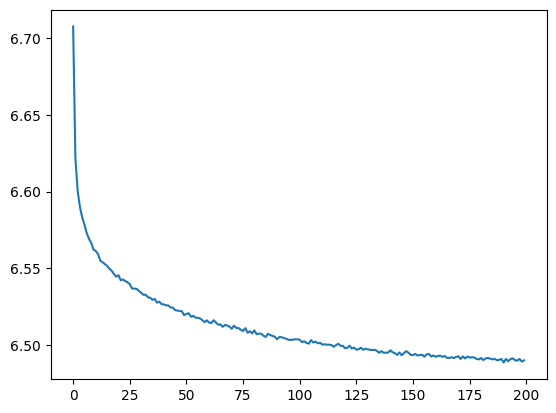

3564

In [25]:
plt.plot(loss_history, linestyle = 'solid')
plt.show()
gc.collect()

In [18]:
# model A
integrater.to(torch.device("cpu"))
integrater.eval()
for i in range(3):
    integrater.translators[i].to(torch.device("cpu"))

X_tensor_A=torch.tensor(X_cj).float()
X_tensor_B=torch.tensor(X_mm).float()
X_tensor_C=torch.tensor(X_hs).float()

x_atoa=integrater.translators[0](X_tensor_A)
_, z_a=integrater.encoder(x_atoa)

x_btoa=integrater.translators[1](X_tensor_B)
_, z_b=integrater.encoder(x_btoa)

x_ctoa=integrater.translators[2](X_tensor_C)
_, z_c=integrater.encoder(x_ctoa)

In [27]:
# model B
integraterB.to(torch.device("cpu"))
integraterB.eval()
for i in range(3):
    integraterB.matrixA[i].to(torch.device("cpu"))

X_tensor_A=torch.tensor(X_cj).float()
X_tensor_B=torch.tensor(X_mm).float()
X_tensor_C=torch.tensor(X_hs).float()

x_atoa = integraterB.matrixA[0](X_tensor_A)
x_atoa = integraterB.matrixB(x_atoa)
x_atoa = integraterB.batchnorm(x_atoa)
_, z_a=integraterB.encoder(x_atoa)

x_btoa = integraterB.matrixA[1](X_tensor_B)
x_btoa = integraterB.matrixB(x_btoa)
x_btoa = integraterB.batchnorm(x_btoa)
_, z_b=integraterB.encoder(x_btoa)

x_ctoa = integraterB.matrixA[2](X_tensor_C)
x_ctoa = integraterB.matrixB(x_ctoa)
x_ctoa = integraterB.batchnorm(x_ctoa)
_, z_c=integraterB.encoder(x_ctoa)

In [28]:
z_a = torch.Tensor.cpu(z_a).detach().numpy()
z_b = torch.Tensor.cpu(z_b).detach().numpy()
z_c = torch.Tensor.cpu(z_c).detach().numpy()

In [29]:
adata = query_rna1.concatenate(query_rna2, query_rna3)

In [30]:
adata.obsm['X_multivib'] = np.concatenate((z_a, z_b, z_c),0)

In [31]:
# sc.pp.subsample(adata, fraction=0.8)
sc.pp.neighbors(adata, use_rep='X_multivib', n_neighbors=15, 
                metric='correlation', method='umap')
sc.tl.umap(adata,min_dist=0.15)

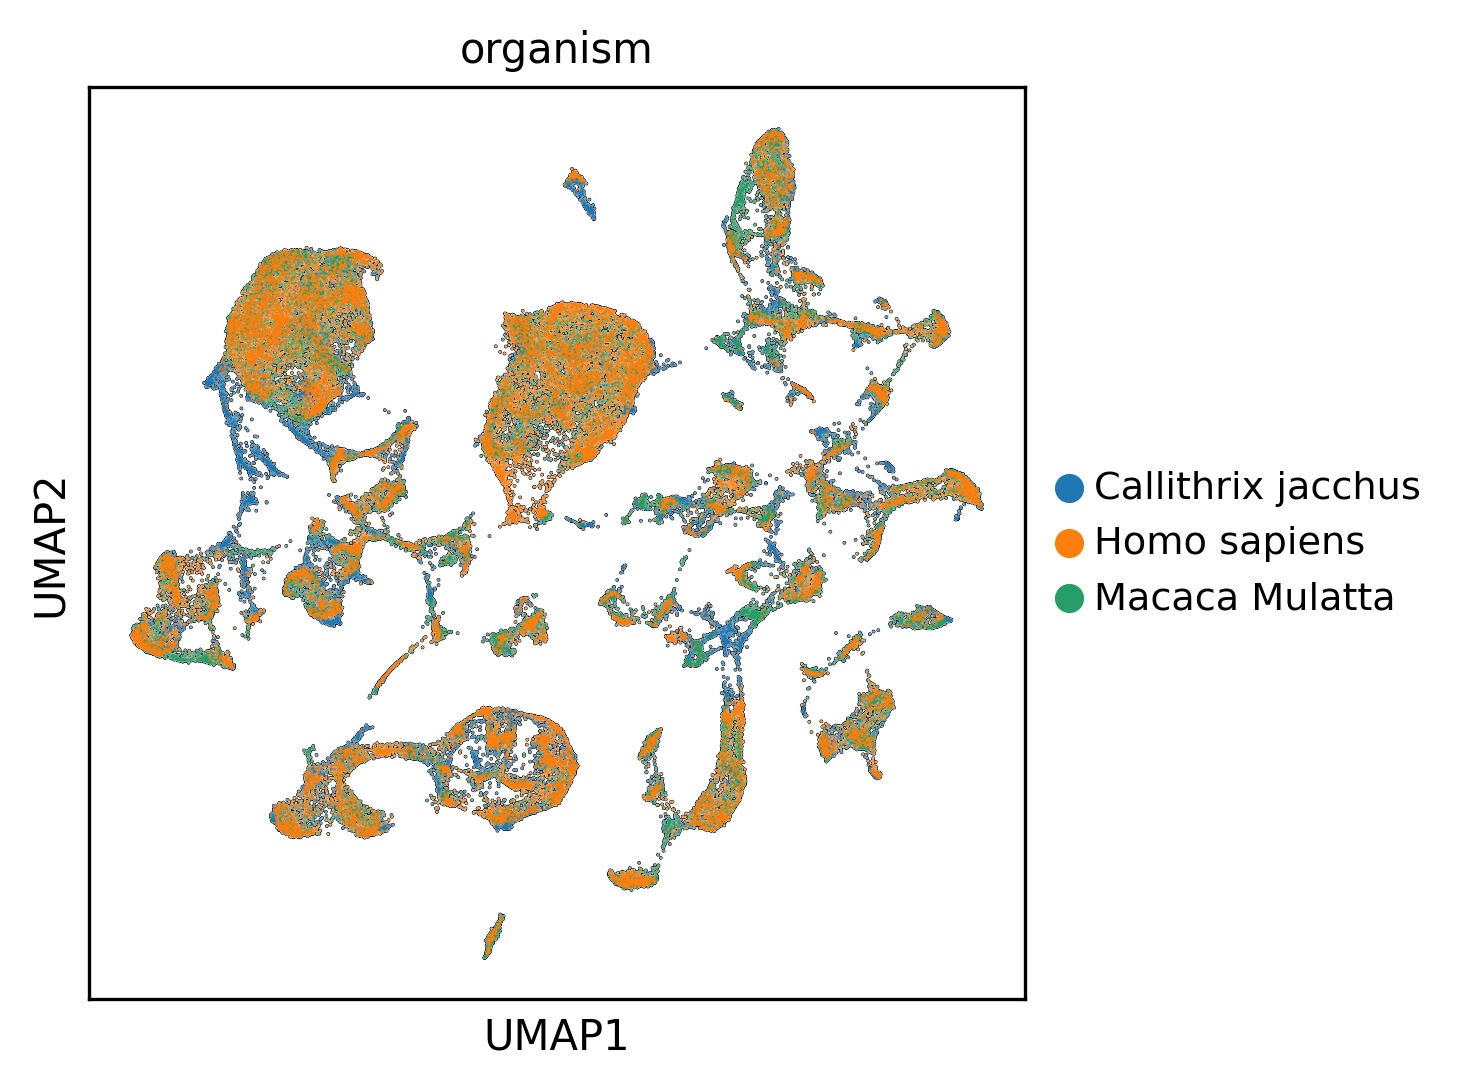

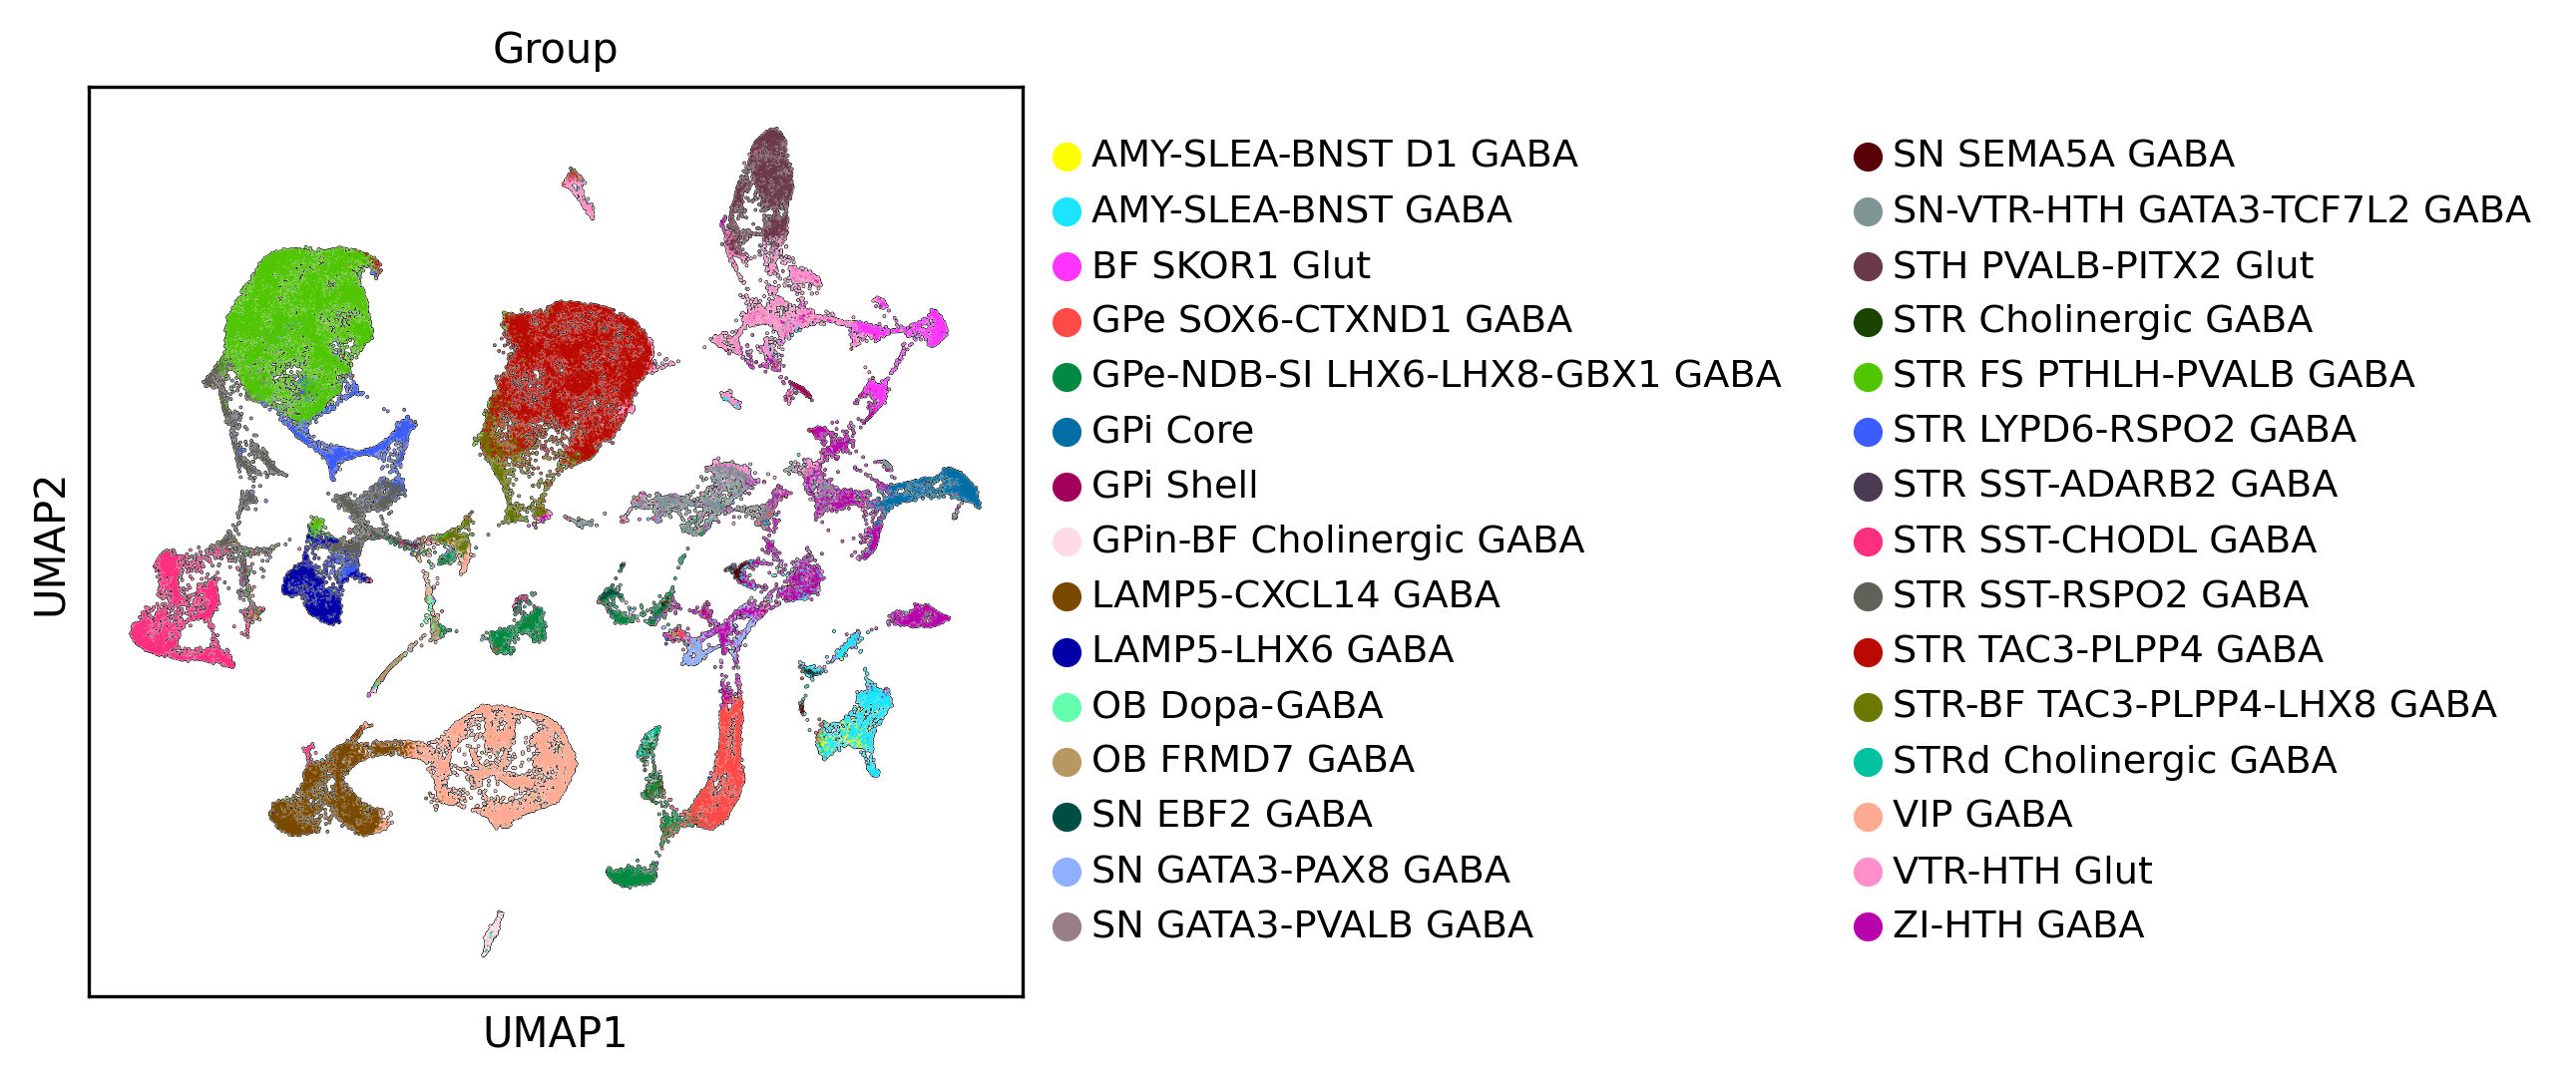

In [32]:
##Visualization of integration outcome
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=150, fontsize=10, 
                     vector_friendly=True)
sc.pl.umap(adata,
           color=['organism'], add_outline=True,
           ncols=1)

sc.pl.umap(adata,
           color=['Group'], add_outline=True,
           ncols=1)